In [1]:
from PIL import Image, ImageDraw, ImageFont

In [2]:
from os import listdir

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import re
import os
import gc
import sys

In [13]:
import seaborn as sns
import cv2
import shutil
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [22]:
fontsize = 50


font = ImageFont.truetype('NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')

In [139]:
#Function takes input as a file name and labels in string format and returns images with bounng box.
def visualize_training_data(image_fn, labels):
        # Convert annotation string to array
        labels = np.array(labels.split(' ')).reshape(-1,5)
        
        #Read Image
        imsource = Image.open(image_fn).convert('RGBA')
        bbox_canvas = Image.new('RGBA', imsource.size)
        char_canvas = Image.new('RGBA', imsource,size)
        bbox_draw = ImageDraw.Draw(bbox_canvas) 
        char_draw = ImageDraw.Draw(char_canvas)
        
        for codepoint, x, y, w, h in labels:
            x, y, w, h = int(x), int(y), int(w), int(h)
            char = unicode_map[codepoint]
            
            bbox_draw.rectangle((x,y,x+w,y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
            char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill = (0, 0, 255, 255), font = font)
            
            imsource = Image.aplha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
            imsource = imsource.convert("RGB")
            
            return np.asarray(imsource)
        
def visualize_test_data(image_fn):

    imsource = Image.open(image_fn).convert('RGBA')
    imsource = imsource.convert("RGB")
    return np.asarray(imsource)    

In [140]:
# This function takes in a filename of an image, and the labels in the string format given in a submission csv, and returns an image with the characters and predictions annotated.
def visualize_predictions(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 3)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y in labels:
        x, y = int(x), int(y)
        char = unicode_map[codepoint] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x-10, y-10, x+10, y+10), fill=(255, 0, 0, 255))
        char_draw.text((x+25, y-fontsize*(3/4)), char, fill=(255, 0, 0, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

In [141]:
df_train = pd.read_csv('train.csv')
df_test = os.listdir('Images/test/')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('unicode_translation.csv').values}
print ("TRAIN: ", df_train.shape)
print ("TEST: ", len(df_test))
df_train.head()

TRAIN:  (3881, 2)
TEST:  4150


,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [143]:
df_train.isnull().sum()

image_id      0
labels      276
dtype: int64

In [144]:
df_train.dropna(inplace=True)
df_train.reset_index(inplace=True, drop=True)
print ("TRAIN: ", df_train.shape)

TRAIN:  (3605, 2)


In [153]:
chars = {}

for i in range (df_train.shape[0]):
    try:
        a = [x for x in df_train.labels.values[i].split(' ') if x.startswith('U')]
        n_a = int(len(a))
        for j in a:
            if j not in chars: chars[j] = 1
            else:
                chars[j]+=1
                
        a = " ".join(a)
            
    except AttributeError:
        a = None
        n_a = 0
            
    df_train.loc[i, 'chars'] = a
    df_train.loc[i, 'n_chars'] = n_a
        
df_train.head()

,image_id,labels,chars,n_chars
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...,U+306F U+304C U+3044 U+3051 U+306B U+306B U+30...,67.0
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...,U+306F U+304B U+304B U+3044 U+306B U+306B U+30...,80.0
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...,U+306F U+306E U+3078 U+304C U+306B U+3081 U+30...,78.0
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...,U+3082 U+516B U+309E U+306B U+308B U+304B U+30...,72.0
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...,U+309D U+309D U+309D U+309D U+3078 U+309D U+25...,167.0


In [154]:
print("MAX chars in a picture = ", df_train.n_chars.max())
print("MIN chars in a picture = ", df_train.n_chars.min())
print("MEAN chars in a picture = ", df_train.n_chars.mean())

MAX chars in a picture =  614.0
MIN chars in a picture =  2.0
MEAN chars in a picture =  189.5877947295423


In [156]:
chars = pd.DataFrame(list(chars.items()), columns = ['char','count'])
chars['jp_char'] = chars['char'].map(unicode_map)
print(" Chars dataframe ")
print("Number of chars: ", chars.shape[0])
chars.to_csv("chars_freq.csv", index = False)
chars.head()

 Chars dataframe 
Number of chars:  4212


,char,count,jp_char
0,U+306F,14759,は
1,U+304C,6740,が
2,U+3044,11903,い
3,U+3051,4224,け
4,U+306B,24685,に


In [157]:
chars.sort_values(by=['count'], ascending = False).head(10).reset_index()

,index,char,count,jp_char
0,4,U+306B,24685,に
1,5,U+306E,24136,の
2,55,U+3057,22209,し
3,22,U+3066,20569,て
4,10,U+3068,16588,と
5,28,U+3092,15743,を
6,0,U+306F,14759,は
7,25,U+304B,14342,か
8,70,U+308A,14184,り
9,38,U+306A,13750,な


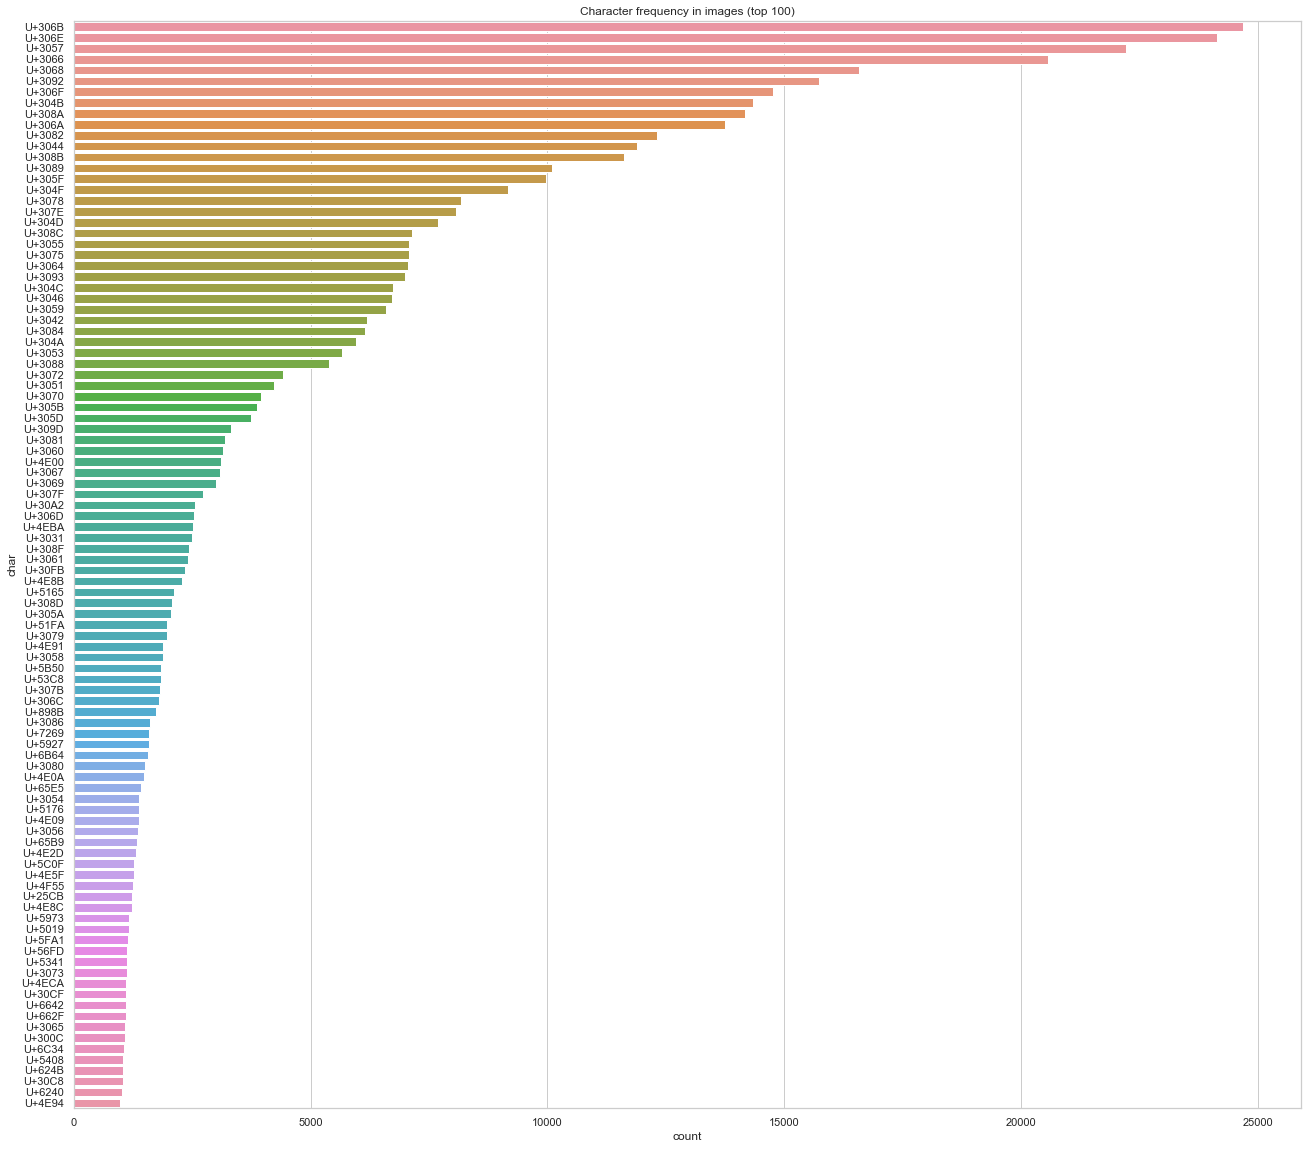

In [158]:
sns.set(style="whitegrid")
plt.figure(figsize=(22,20))
ax = sns.barplot(y="char", x="count", data=chars.sort_values(by=['count'], ascending=False).head(100))
ax.set_title("Character frequency in images (top 100)")
plt.show()